In [1]:
import os
import numpy as np
import pandas as pd
import warnings
from copy import deepcopy
import torch
from torch.utils.data import DataLoader
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForCausalLM, Pipeline, BitsAndBytesConfig
from torchmetrics.functional import calibration_error

# plotting
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve, CalibrationDisplay
# import seaborn as sns

# progress bar for notebooks
from tqdm.notebook import tqdm

# check if HF_HOME is set
assert "HF_HOME" in os.environ, "HF_HOME is not set"
print("models live at: ", os.environ["HF_HOME"])

# check if cuda is available, if not, use mps (if available)
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
    warnings.warn("No CUDA or MPS device available, using CPU")
print("using device: ", device)

models live at:  /shared_data0/jrudoler/.cache/huggingface/
using device:  cpu


/tmp/ipykernel_294023/1003924994.py:33: UserWarning: No CUDA or MPS device available, using CPU
  warnings.warn("No CUDA or MPS device available, using CPU")


## Create data for learning basic functions 

In [ ]:
# Load model directly
model_id = "meta-llama/Llama-3.2-1B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id)
model.generation_config.pad_token_id = tokenizer.eos_token_id
model.generation_config.return_dict_in_generate = True
model.generation_config.output_scores = True

In [ ]:
# pipe = pipeline(
#     "text-generation",
#     model=model,
#     tokenizer=tokenizer,
#     torch_dtype=torch.bfloat16,
#     device=device,
# )

In [4]:
# Generate random data for OLS


def generate_dataset(n_samples: int, f, x_std: float, noise_std: float):
    x = np.random.randn(n_samples) * x_std
    y = f(x) + np.random.randn(n_samples) * noise_std
    return pd.DataFrame({"x": x, "y": y})


def linear_model(x, slope: float, intercept: float):
    return slope * x + intercept


def quadratic_model(x, a: float, b: float, c: float):
    return a * x**2 + b * x + c


def log_model(x, a: float, b: float):
    return a * np.log(x) + b


def exp_model(x, a: float, b: float):
    return a * np.exp(b * x)


# Example usage
n_samples = 100
slope = 3
intercept = 2
x_std = 1
noise_std = 0.05

dataset = generate_dataset(n_samples, lambda x: linear_model(x, slope, intercept), x_std, noise_std)
print(dataset.head())

          x         y
0 -0.671339  0.023600
1 -1.496643 -2.490145
2  1.388899  6.182442
3 -1.120351 -1.389129
4 -0.501480  0.554781


In [5]:
# helper function to create a list of messages from a dataset
def create_few_shot_messages(dataset: pd.DataFrame):
    """
    Given a dataframe with columns "x" and "y", create a list of messages for the model.
    If there are m rows, the first m-1 rows will be used as few-shot examples
    and the last row will be the target example.
    """
    messages = []
    for i, row in dataset.iterrows():
        messages.append({"role": "user", "content": f"x = {row['x']}; y = ?"})
        messages.append({"role": "assistant", "content": f"{row['y']}"})
    return messages


def create_query_messages(dataset: pd.DataFrame):
    messages = []
    for i, row in dataset.iterrows():
        messages.append({"role": "user", "content": f"x = {row['x']}; y = ?"})
    return messages


dataset = generate_dataset(n_samples, lambda x: linear_model(x, slope, intercept), x_std, noise_std)
few_shot_messages = create_few_shot_messages(dataset)
query_messages = create_query_messages(dataset)
print(few_shot_messages)
print(query_messages)

[{'role': 'user', 'content': 'x = 1.2984149620645673; y = ?'}, {'role': 'assistant', 'content': '5.884255584027905'}, {'role': 'user', 'content': 'x = 1.2257159848465278; y = ?'}, {'role': 'assistant', 'content': '5.706293890663671'}, {'role': 'user', 'content': 'x = 1.0479860804142018; y = ?'}, {'role': 'assistant', 'content': '5.160517980980212'}, {'role': 'user', 'content': 'x = -0.4344106926623581; y = ?'}, {'role': 'assistant', 'content': '0.6529566556791584'}, {'role': 'user', 'content': 'x = -0.43699356685626717; y = ?'}, {'role': 'assistant', 'content': '0.5769598873613061'}, {'role': 'user', 'content': 'x = -0.2536858491356421; y = ?'}, {'role': 'assistant', 'content': '1.2028505722472371'}, {'role': 'user', 'content': 'x = -1.6949911125100416; y = ?'}, {'role': 'assistant', 'content': '-3.2025075793292466'}, {'role': 'user', 'content': 'x = 1.2546000405742777; y = ?'}, {'role': 'assistant', 'content': '5.7696817793460795'}, {'role': 'user', 'content': 'x = -0.9749501354738932

In [14]:
messages = few_shot_messages + query_messages[0:1]
pipe.model.generation_config.pad_token_id = tokenizer.eos_token_id
pipe.model.generation_config.return_dict_in_generate = True
pipe.model.generation_config.output_scores = True
outputs = pipe(
    messages,
    max_length=5000,
    pad_token_id=tokenizer.eos_token_id,
)
print(messages[-1])
print(outputs[0])

{'role': 'user', 'content': 'x = 1.2984149620645673; y = ?'}
{'generated_text': [{'role': 'user', 'content': 'x = 1.2984149620645673; y = ?'}, {'role': 'assistant', 'content': '5.884255584027905'}, {'role': 'user', 'content': 'x = 1.2257159848465278; y = ?'}, {'role': 'assistant', 'content': '5.706293890663671'}, {'role': 'user', 'content': 'x = 1.0479860804142018; y = ?'}, {'role': 'assistant', 'content': '5.160517980980212'}, {'role': 'user', 'content': 'x = -0.4344106926623581; y = ?'}, {'role': 'assistant', 'content': '0.6529566556791584'}, {'role': 'user', 'content': 'x = -0.43699356685626717; y = ?'}, {'role': 'assistant', 'content': '0.5769598873613061'}, {'role': 'user', 'content': 'x = -0.2536858491356421; y = ?'}, {'role': 'assistant', 'content': '1.2028505722472371'}, {'role': 'user', 'content': 'x = -1.6949911125100416; y = ?'}, {'role': 'assistant', 'content': '-3.2025075793292466'}, {'role': 'user', 'content': 'x = 1.2546000405742777; y = ?'}, {'role': 'assistant', 'conte

In [5]:
def prompt_and_predict(messages: list[dict], pipeline: Pipeline):
    pipeline.model.generation_config.pad_token_id = pipeline.tokenizer.eos_token_id
    pipeline.model.generation_config.return_dict_in_generate = True
    outputs = pipeline(messages, max_length=5000, pad_token_id=pipeline.tokenizer.eos_token_id, output_scores=True)
    return outputs  # [0]["generated_text"][-1]

In [80]:
ols = LinearRegression()
ols.fit(dataset["x"].values.reshape(-1, 1), dataset["y"].values)

ols.predict(dataset["x"].iloc[-1].reshape(1, -1))

array([1.17567767])

In [104]:
res = prompt_and_predict(few_shot_messages + query_messages[0:1], pipe)

In [107]:
res[0]

{'generated_text': [{'role': 'user',
   'content': 'x = -0.45903432938493827; y = ?'},
  {'role': 'assistant', 'content': '0.6400286257124784'},
  {'role': 'user', 'content': 'x = -0.7640071102714826; y = ?'},
  {'role': 'assistant', 'content': '-0.3166311849470841'},
  {'role': 'user', 'content': 'x = 2.39709748832622; y = ?'},
  {'role': 'assistant', 'content': '9.193544841312868'},
  {'role': 'user', 'content': 'x = -0.5033711887173068; y = ?'},
  {'role': 'assistant', 'content': '0.5073557515539322'},
  {'role': 'user', 'content': 'x = 0.37005520438959516; y = ?'},
  {'role': 'assistant', 'content': '3.180338410926132'},
  {'role': 'user', 'content': 'x = 0.520129111076402; y = ?'},
  {'role': 'assistant', 'content': '3.4983364943523214'},
  {'role': 'user', 'content': 'x = -1.4774222656568894; y = ?'},
  {'role': 'assistant', 'content': '-2.3957641491933366'},
  {'role': 'user', 'content': 'x = -0.28323129890452364; y = ?'},
  {'role': 'assistant', 'content': '1.0953330439664344'}

In [94]:
input = tokenizer.encode("x = 1; y = ?", return_tensors="pt").to(device)
model.generate(input, max_new_tokens=256, output_scores=True)
# print(tokenizer.decode([-1]))


GenerateDecoderOnlyOutput(sequences=tensor([[128000,     87,    284,    220,     16,     26,    379,    284,    949,
             26,   1167,    284,    865,    489,    379,    280,     88,    284,
            220,     20,     26,   1167,    284,    865,    489,    379,    280,
             88,    284,    220,    605,     26,   1167,    284,    865,    489,
            379,    280,     88,    284,    220,    508,     26,   1167,    284,
            865,    489,    379,    280,     88,    284,    220,    966,     26,
           1167,    284,    865,    489,    379,    280,     88,    284,    220,
           1272,     26,   1167,    284,    865,    489,    379,    280,     88,
            284,    220,   1135,     26,   1167,    284,    865,    489,    379,
            280,     88,    284,    220,   1399,     26,   1167,    284,    865,
            489,    379,    280,     88,    284,    220,   2031,     26,   1167,
            284,    865,    489,    379,    280,     88,    284,    220, 

In [73]:
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

few_shot_messages = create_few_shot_messages(train_dataset)
query_messages = create_query_messages(test_dataset)

for i, test_row in test_dataset.reset_index().iterrows():
    print(i, query_messages[i : i + 1])
    full_prompt_messages = few_shot_messages + query_messages[i : i + 1]
    pred = prompt_and_predict(full_prompt_messages, pipe)
    print(pred)
    print(f"x = {test_row['x']}; y = {test_row['y']}; pred = {pred}")


0 [{'role': 'user', 'content': 'x = -1.5047226363170778; y = ?'}]
{'role': 'assistant', 'content': '-2.1610111244455165'}
x = -1.5047226363170778; y = -2.457422877718286; pred = {'role': 'assistant', 'content': '-2.1610111244455165'}
1 [{'role': 'user', 'content': 'x = -0.9317807036702849; y = ?'}]
{'role': 'assistant', 'content': '-0.6956379113301794'}
x = -0.9317807036702849; y = -0.8476896227162707; pred = {'role': 'assistant', 'content': '-0.6956379113301794'}
2 [{'role': 'user', 'content': 'x = -0.04854387364964442; y = ?'}]
{'role': 'assistant', 'content': '1.9119265559560114'}
x = -0.04854387364964442; y = 1.8174565677505468; pred = {'role': 'assistant', 'content': '1.9119265559560114'}
3 [{'role': 'user', 'content': 'x = 1.1076373389582772; y = ?'}]
{'role': 'assistant', 'content': '5.33478610955586'}
x = 1.1076373389582772; y = 5.269385592413651; pred = {'role': 'assistant', 'content': '5.33478610955586'}
4 [{'role': 'user', 'content': 'x = -0.46746945950087276; y = ?'}]
{'rol

## SST-2

In [2]:
## NOTE LLAMA HAS THE FOLLOWING DEFAULT CONFIG:
# {
#   "_from_model_config": true,
#   "bos_token_id": 128000,
#   "eos_token_id": 128001,
#   "transformers_version": "4.45.0.dev0",
#   "do_sample": true,
#   "temperature": 0.6,
#   "top_p": 0.9
# }

In [101]:
###SST-2
import polars as pl
from data_handling import create_few_shot_sst2_messages, SST2Dataset

splits = {
    "train": "data/train-00000-of-00001.parquet",
    "validation": "data/validation-00000-of-00001.parquet",
    "test": "data/test-00000-of-00001.parquet",
}
sst2_train = pl.read_parquet("hf://datasets/stanfordnlp/sst2/" + splits["train"])
sst2_test = pl.read_parquet("hf://datasets/stanfordnlp/sst2/" + splits["test"])


In [3]:
# Load model directly
model_id = "google/gemma-2-2b-it"
# model_id = "meta-llama/Llama-3.2-1B-Instruct"
# use 8-bit quantization
# quantization_config = BitsAndBytesConfig(load_in_8bit=True)
# model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto", quantization_config=quantization_config)
# left padding for generation
model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto", torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_id, padding_side="left")
print("Original model.generation_config:\n", model.generation_config)
tokenizer.pad_token_id = tokenizer.eos_token_id
model.generation_config.pad_token_id = tokenizer.eos_token_id
model.generation_config.return_dict_in_generate = True
model.generation_config.output_scores = True
model.generation_config.do_sample = False
model.generation_config.temperature = None
model.generation_config.top_p = None
print("Updated model.generation_config:\n", model.generation_config)

print("tokenizer.pad_token_id: ", tokenizer.pad_token_id)
print("tokenizer.eos_token_id: ", tokenizer.eos_token_id)

# if torch.cuda.device_count() > 1:
#     print("Using multiple GPUs!")
#     model = DataParallel(model)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Original model.generation_config:
 GenerationConfig {
  "bos_token_id": 2,
  "cache_implementation": "hybrid",
  "eos_token_id": [
    1,
    107
  ],
  "pad_token_id": 0
}

Updated model.generation_config:
 GenerationConfig {
  "bos_token_id": 2,
  "cache_implementation": "hybrid",
  "eos_token_id": [
    1,
    107
  ],
  "output_scores": true,
  "pad_token_id": 1,
  "return_dict_in_generate": true,
  "temperature": null,
  "top_p": null
}

tokenizer.pad_token_id:  1
tokenizer.eos_token_id:  1


In [5]:
tokenizer.chat_template

"{{ bos_token }}{% if messages[0]['role'] == 'system' %}{{ raise_exception('System role not supported') }}{% endif %}{% for message in messages %}{% if (message['role'] == 'user') != (loop.index0 % 2 == 0) %}{{ raise_exception('Conversation roles must alternate user/assistant/user/assistant/...') }}{% endif %}{% if (message['role'] == 'assistant') %}{% set role = 'model' %}{% else %}{% set role = message['role'] %}{% endif %}{{ '<start_of_turn>' + role + '\n' + message['content'] | trim + '<end_of_turn>\n' }}{% endfor %}{% if add_generation_prompt %}{{'<start_of_turn>model\n'}}{% endif %}"

In [11]:
config = {
    "batch_size": 8,
    "seed": 42,
    "n_context": 16,  # 500
    "n_target": 500,  # 500
}
context_samples = sst2_train.sample(config["n_context"], seed=config["seed"])
target_samples = sst2_test.sample(config["n_target"], seed=config["seed"])
target_messages = create_few_shot_sst2_messages(context_samples, target_samples)

In [12]:
target_messages[0]

[{'role': 'assistant',
  'content': 'I will classify the given text with label 0 or 1.'},
 {'role': 'user', 'content': 'the most moronic screenplays of the year , '},
 {'role': 'assistant', 'content': '0'},
 {'role': 'user', 'content': 'confused , and totally disorientated '},
 {'role': 'assistant', 'content': '0'},
 {'role': 'user', 'content': 'strain '},
 {'role': 'assistant', 'content': '0'},
 {'role': 'user',
  'content': 'lessen the overall impact the movie could have had '},
 {'role': 'assistant', 'content': '0'},
 {'role': 'user',
  'content': 'that movie nothing more than a tepid exercise in '},
 {'role': 'assistant', 'content': '0'},
 {'role': 'user', 'content': 'muck '},
 {'role': 'assistant', 'content': '0'},
 {'role': 'user', 'content': 'ideal outlet '},
 {'role': 'assistant', 'content': '1'},
 {'role': 'user', 'content': 'probably should '},
 {'role': 'assistant', 'content': '1'},
 {'role': 'user',
  'content': 'sustain its initial promise with a jarring , new-agey tone cr

In [18]:
string_batch

['<bos><start_of_turn>model\nI will classify the given text with label 0 or 1.<end_of_turn>\n<start_of_turn>user\nthe most moronic screenplays of the year ,<end_of_turn>\n<start_of_turn>model\n0<end_of_turn>\n<start_of_turn>user\nconfused , and totally disorientated<end_of_turn>\n<start_of_turn>model\n0<end_of_turn>\n<start_of_turn>user\nstrain<end_of_turn>\n<start_of_turn>model\n0<end_of_turn>\n<start_of_turn>user\nlessen the overall impact the movie could have had<end_of_turn>\n<start_of_turn>model\n0<end_of_turn>\n<start_of_turn>user\nthat movie nothing more than a tepid exercise in<end_of_turn>\n<start_of_turn>model\n0<end_of_turn>\n<start_of_turn>user\nmuck<end_of_turn>\n<start_of_turn>model\n0<end_of_turn>\n<start_of_turn>user\nideal outlet<end_of_turn>\n<start_of_turn>model\n1<end_of_turn>\n<start_of_turn>user\nprobably should<end_of_turn>\n<start_of_turn>model\n1<end_of_turn>\n<start_of_turn>user\nsustain its initial promise with a jarring , new-agey tone creeping into the seco

In [22]:
tokenizer.chat_template = "{{ bos_token }}{% if messages[0]['role'] == 'system' %}{{ raise_exception('System role not supported') }}{% endif %}{% for message in messages %}{% if (message['role'] == 'assistant') %}{% set role = 'model' %}{% else %}{% set role = message['role'] %}{% endif %}{{ '<start_of_turn>' + role + '\n' + message['content'] | trim + '<end_of_turn>\n' }}{% endfor %}{% if add_generation_prompt %}{{'<start_of_turn>model\n'}}{% endif %}"
string_batch = tokenizer.apply_chat_template(
    target_messages[0:2], tokenize=False, add_generation_prompt=True, padding=True
)
# use batch_encode_plus to get the attention mask as well
batch_tokens = tokenizer.batch_encode_plus(string_batch, return_tensors="pt", padding=True).to(device)
outputs = model.generate(**batch_tokens, max_new_tokens=1, output_logits=True, renormalize_logits=False)
print(tokenizer.batch_decode(outputs["sequences"][:, -1:]))
print(batch_tokens["input_ids"][:, -20:])
print(outputs["logits"])

['1', '1']
tensor([[   106,   1645,    108, 235250,  37277,    578,  59919, 118466,  69439,
          13051,    978,   3920,   1178,  10523,    954,    107,    108,    106,
           2516,    108],
        [ 10140,    611,   6871,   4942,    576,  62305,    578,  21286,   3297,
          21286,    674,   4549,    675,   3281,    954,    107,    108,    106,
           2516,    108]], device='cuda:0')
(tensor([[-7.8438,  4.9688, -0.6914,  ..., -3.7500, -4.7500, -4.8125],
        [-6.8438,  6.5625, -0.5898,  ..., -2.7344, -3.8125, -3.6562]],
       device='cuda:0'),)


In [5]:
# build a dataloader
dataset = SST2Dataset(target_messages)
# enable mapping to device
loader = DataLoader(dataset, batch_size=config["batch_size"], shuffle=False, collate_fn=lambda x: x)

: 

In [6]:
# batched version
batch_size = config["batch_size"]
n_batches = len(target_messages) // batch_size
test_preds = []
test_probs = []
for batch_messages in tqdm(loader):
    # convert to string with special tokens, including the generation prompt
    batch_messages_str = tokenizer.apply_chat_template(
        batch_messages,
        tokenize=False,
        add_generation_prompt=True,
    )
    # use batch_encode_plus to get the attention mask as well
    # need padding on the left
    assert tokenizer.padding_side == "left"
    batch_tokens = tokenizer.batch_encode_plus(batch_messages_str, return_tensors="pt", padding=True).to(device)
    outputs = model.generate(
        **batch_tokens, max_new_tokens=10, output_scores=True, output_logits=True, renormalize_logits=True
    )
    # sequences are of shape (n_sequences, n_total_tokens)
    # we only care about the last token, excluding the EOS token
    preds = tokenizer.batch_decode(outputs["sequences"][:, -2:], skip_special_tokens=True)
    test_preds.extend([int(pred) for pred in preds])
    # logits are a tuple of length n_generated_tokens, each element being
    # a tensor of shape (batch_size, n_vocab)
    # we should only care about the last token, excluding the EOS token, which is also the first generated token
    # probs = np.array(
    #     [torch.softmax(logits[0], dim=-1).max(dim=-1).values.cpu().numpy() for logits in outputs["logits"]]
    # ).tolist()
    probs = torch.softmax(outputs["logits"][0], dim=-1).max(dim=-1).values.cpu().numpy().tolist()
    test_probs.extend(probs)
test_preds = np.array(test_preds)
test_probs = np.array(test_probs)
test_labels = target_samples["label"].to_numpy()

# convert to df and save
test_df = pd.DataFrame(
    {
        "target_idx": target_samples["idx"].to_numpy(),
        "sentence": target_samples["sentence"].to_numpy(),
        "pred": test_preds,
        "prob": test_probs,
        "true_label": test_labels,
        "context_idx": [context_samples["idx"].to_list()] * config["n_target"],
    }
)
# add config as metadata
test_df.attrs["config"] = config
test_df.to_csv(f"results/sst2_test_{model_id.replace('/', '_')}.csv", index=False)
test_df.to_pickle(f"results/sst2_test_{model_id.replace('/', '_')}.pkl")

  0%|          | 0/63 [00:00<?, ?it/s]

Error invalid configuration argument at line 525 in file /src/csrc/ops.cu


In [3]:
def plot_calibration_curve(test_labels, test_probs, model_id, n_bins=5, save=False):
    prob_true, prob_pred = calibration_curve(test_labels, test_probs, n_bins=n_bins, strategy="quantile")
    CalibrationDisplay(prob_true, prob_pred, "SST-2").plot()
    plt.ylabel("Proportion of positive samples")
    plt.xlabel("Mean predicted probability")
    
    if save:
        plt.savefig(f"figures/reliability_diagram_{n_bins}_bins_{model_id.replace('/', '_')}.png")
    
    plt.show()


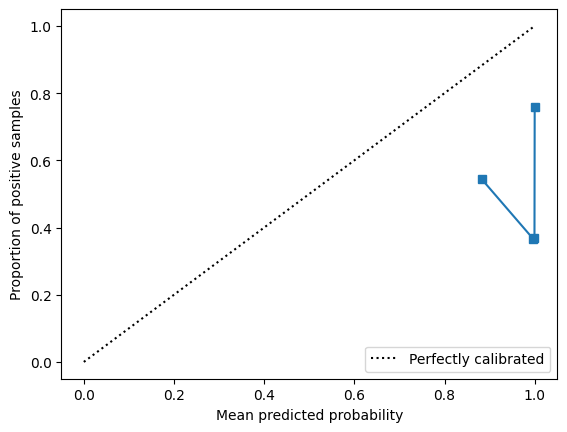

In [5]:
results = pd.read_pickle("results/sst2_context_256_meta-llama_Llama-3.3-70B-Instruct.pkl")
# Call the function
plot_calibration_curve(results["true_label"], results["prob"], "meta-llama/Llama-3.3-70B-Instruct", n_bins=4, save=False)


In [92]:
def expected_calibration_error(y_true, y_prob, n_bins=10, method="quantile", multiclass=False) -> float:
    if multiclass:
        # Get the top-1 predicted class and its probability
        top1_probs = np.max(y_prob, axis=1)
        top1_preds = np.argmax(y_prob, axis=1)
        print(top1_probs)
        print(top1_preds)
        # Create a binary array indicating whether the top-1 prediction is correct
        correct_preds = (top1_preds == y_true).astype(int)
        y_prob = top1_probs
        y_true = correct_preds

    if method == "uniform":
        bin_counts, bin_edges = np.histogram(y_prob, bins=np.linspace(0, 1, n_bins+1))
    elif method == "quantile":
        bin_counts, bin_edges = np.histogram(y_prob, bins=np.quantile(y_prob, np.linspace(0, 1, n_bins+1)))
    else:
        raise ValueError(f"Invalid method: {method}")

    bin_proportions = bin_counts / bin_counts.sum()
    bin_indices = np.digitize(y_prob, bin_edges, right=True)
    bin_accuracies = np.array([
        (y_true[bin_indices == i]).mean() if np.any(bin_indices == i) else 0
        for i in range(1, n_bins+1)
    ])
    bin_probs = np.array([
        (y_prob[bin_indices == i]).mean() if np.any(bin_indices == i) else 0
        for i in range(1, n_bins+1)
    ])
    ece = np.sum(bin_proportions * np.abs(bin_probs - bin_accuracies))
    return ece

# unit test
n_bins = 8
y_true = np.array([0, 0, 0, 1, 1, 1, 0, 0, 0, 1])
y_prob = np.array([0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91, 1])
print(expected_calibration_error(y_true, y_prob, n_bins=8, method="uniform"))
print(calibration_error(torch.tensor(y_prob), torch.tensor(y_true), task="binary", n_bins=8, norm="l1"))

# unit test for multiclass
n_bins = 8
y_true = np.array([0, 0, 0, 2, 2, 2, 1, 1, 1, 2])
y_prob = np.array([[0.1, 0.2, 0.7], [0.3, 0.4, 0.3], [0.4, 0.5, 0.1], [0.1, 0.2, 0.7], [0.3, 0.4, 0.3], [0.4, 0.5, 0.1], [0.1, 0.2, 0.7], [0.3, 0.4, 0.3], [0.4, 0.5, 0.1], [0.1, 0.2, 0.7]])
print(expected_calibration_error(y_true, y_prob, n_bins=8, method="uniform", multiclass=True))
# preds tensor needs to be of shape (n_samples, n_classes)
print(calibration_error(torch.tensor(y_prob), torch.tensor(y_true), task="multiclass", num_classes=3, n_bins=8, norm="l1"))


0.453
tensor(0.4530, dtype=torch.float64)
[0.7 0.4 0.5 0.7 0.4 0.5 0.7 0.4 0.5 0.7]
[2 1 1 2 1 1 2 1 1 2]
0.11499999999999999
tensor(0.1500)


In [177]:
# import seaborn as sns

model_ids = ["meta-llama/Llama-3.2-1B-Instruct", "meta-llama/Llama-3.2-3B-Instruct", "meta-llama/Llama-3.3-70B-Instruct", "google/gemma-2-2b-it", "google/gemma-2-9b-it", "tiiuae/Falcon3-10B-Instruct"]  
full_results = []
for model_id in model_ids:
    for n_context in [8, 16, 32, 64, 128, 256, 512]:
        try:
            results = pd.read_pickle(f"results/sst2_context_{n_context}_{model_id.replace('/', '_')}.pkl")
            results["model_id"] = model_id
            results["n_context"] = n_context
            full_results.append(results)
            assert len(results) == 1500, f"Expected 1500 samples, got {len(results)} for {model_id} with {n_context} context samples"
        except FileNotFoundError:
            print(f"File not found for {n_context} context samples")
            continue
        except Exception as e:
            print(e)
full_results = pd.concat(full_results)
full_results["correct"] = full_results["pred"] == full_results["true_label"]
# sns.histplot(results["prob"], hue=results["true_label"], multiple="stack")


File not found for 8 context samples
File not found for 8 context samples
File not found for 8 context samples
Expected 1500 samples, got 500 for meta-llama/Llama-3.3-70B-Instruct with 32 context samples
Expected 1500 samples, got 500 for meta-llama/Llama-3.3-70B-Instruct with 64 context samples
Expected 1500 samples, got 500 for meta-llama/Llama-3.3-70B-Instruct with 256 context samples
File not found for 512 context samples
File not found for 8 context samples
File not found for 32 context samples
File not found for 64 context samples
File not found for 128 context samples
File not found for 256 context samples
File not found for 512 context samples
File not found for 8 context samples
File not found for 16 context samples
File not found for 512 context samples
File not found for 8 context samples
File not found for 16 context samples
File not found for 32 context samples
File not found for 64 context samples
File not found for 128 context samples
File not found for 256 context sampl

In [181]:
ece_results = full_results.groupby(["model_id", "n_context"]).apply(
    lambda x: expected_calibration_error(x["true_label"], x["prob"], n_bins=15, method="uniform"), include_groups=False
).reset_index().rename(columns={0: "ece"})

In [188]:
for group, group_results in full_results.groupby(["model_id", "n_context"]):
    print(group)
    ece = expected_calibration_error(group_results["true_label"], group_results["prob"], n_bins=15, method="uniform")
    print(ece)
    print(calibration_error(torch.tensor(group_results["prob"]), torch.tensor(group_results["true_label"]), task="binary", n_bins=15, norm="l1"))


('google/gemma-2-2b-it', np.int64(16))
0.35615152907371517
tensor(0.3562, dtype=torch.float64)
('google/gemma-2-9b-it', np.int64(32))
0.40704826597372695
tensor(0.4070, dtype=torch.float64)
('google/gemma-2-9b-it', np.int64(64))
0.42023181629180906
tensor(0.4202, dtype=torch.float64)
('google/gemma-2-9b-it', np.int64(128))
0.4111409449577331
tensor(0.4111, dtype=torch.float64)
('google/gemma-2-9b-it', np.int64(256))
0.4077655256589254
tensor(0.4078, dtype=torch.float64)
('meta-llama/Llama-3.2-1B-Instruct', np.int64(16))
0.17448652130365372
tensor(0.1745, dtype=torch.float64)
('meta-llama/Llama-3.2-1B-Instruct', np.int64(32))
0.2033671624759833
tensor(0.2034, dtype=torch.float64)
('meta-llama/Llama-3.2-1B-Instruct', np.int64(64))
0.2780599534710248
tensor(0.2781, dtype=torch.float64)
('meta-llama/Llama-3.2-1B-Instruct', np.int64(128))
0.3021007508436839
tensor(0.3021, dtype=torch.float64)
('meta-llama/Llama-3.2-1B-Instruct', np.int64(256))
0.34208801931142807
tensor(0.3421, dtype=torch.

<Axes: xlabel='n_context', ylabel='correct'>

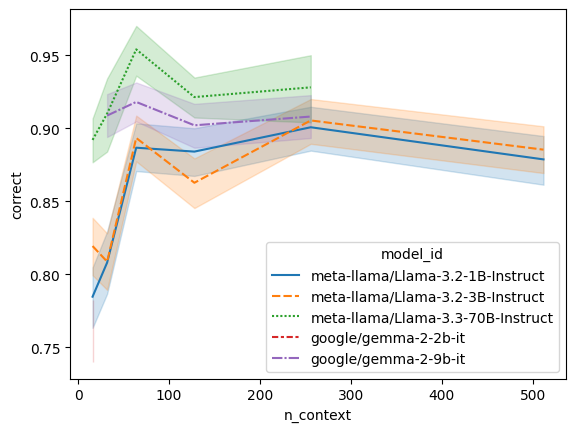

In [185]:
acc_results = full_results.groupby(["model_id", "n_context"]).agg({"correct": "mean"})
sns.lineplot(data=full_results, x="n_context", y="correct", hue="model_id", style="model_id")


<Axes: xlabel='n_context', ylabel='ece'>

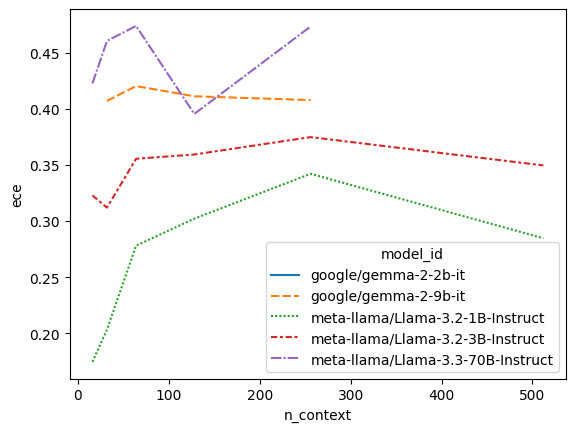

In [187]:
import seaborn as sns
sns.lineplot(data=ece_results.reset_index(), x="n_context", y="ece", hue="model_id", style="model_id")

array([ 0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1., nan,  0.])